# Clustering of stocks

This project will show how to cluster stocks. The tickers of the **S&P600** companies are scrapped from wikipedia. Then, the yfinance API is used to get the stocks prices of all those companies.
The data are then **preprossed, cleaned and formalized**.
Finally, a SOM is used to **clusterise** the stock by group that have the same close price variation.



## Scrap Wikipedia's page

This code scrapps the wikipedia S&P600's page, to retrieve the list of tickers.

In [ ]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import math
from minisom import MiniSom
import numpy as np
df = pd.DataFrame()
# request this url https://en.wikipedia.org/wiki/List_of_S%26P_600_companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_600_companies'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
# get the table by the id constituents
table = soup.find('table', {'id': 'constituents'})
ticker_list = []
# iterate over the tr balise in the table
for tr in table.find_all('tr'):
    # get the first td balise in the tr balise
    td = tr.findAll('td')
    # if the td balise is not empty
    if td is not None and len(td) > 1:
        # get the first a balise in the td balise
        a = td[1].find('a')
        # if the a balise is not empty
        if a is not None:
            # get the text of the a balise
            ticker = a.text
            # add the ticker to the list
            ticker_list.append(ticker)

##

In [2]:
index = 0
df_list = []
period = '5y'
number_of_days = 5*365
ticker_downloaded = []
for ticker in ticker_list:
    print(index, '/', len(ticker_list))
    df_temp = yf.Ticker(ticker).history(period='5y')
    if len(df_temp) < number_of_days//2:
        continue
    else:
        df_temp['Daily Return'] = df_temp['Close'].pct_change()
        ticker_downloaded.append(ticker)
        df_list.append(df_temp)
    index += 1
len(df_list)


0 / 601
0 / 601
1 / 601
2 / 601
3 / 601
4 / 601
5 / 601
6 / 601
7 / 601
8 / 601
9 / 601
10 / 601
11 / 601
12 / 601
13 / 601
14 / 601
14 / 601
15 / 601
16 / 601
17 / 601
18 / 601
19 / 601
20 / 601
21 / 601
22 / 601
23 / 601
24 / 601
25 / 601
26 / 601
27 / 601
28 / 601
29 / 601
30 / 601
31 / 601
32 / 601
33 / 601
34 / 601
35 / 601
36 / 601
37 / 601
38 / 601
39 / 601
40 / 601
41 / 601
42 / 601
43 / 601
44 / 601
45 / 601
45 / 601
46 / 601
47 / 601
48 / 601
48 / 601
49 / 601
50 / 601
51 / 601
52 / 601
53 / 601
54 / 601
55 / 601
56 / 601
57 / 601
58 / 601
59 / 601
60 / 601
61 / 601
62 / 601
63 / 601
64 / 601
65 / 601
66 / 601
67 / 601
68 / 601
69 / 601
70 / 601
71 / 601
72 / 601
73 / 601
74 / 601
75 / 601
76 / 601
77 / 601
78 / 601
79 / 601
80 / 601
81 / 601
82 / 601
83 / 601
84 / 601
85 / 601
86 / 601
87 / 601
88 / 601
89 / 601
90 / 601
91 / 601
92 / 601
93 / 601
94 / 601
95 / 601
96 / 601
97 / 601
98 / 601
99 / 601
99 / 601
100 / 601
101 / 601
102 / 601
103 / 601
104 / 601
104 / 601
105 / 

569

In [3]:
# create a new dataframe list with only the daily return
df_list_daily_return = []
for df in df_list:
    df_list_daily_return.append(df['Daily Return'])

[df.dropna(inplace=True) for df in df_list_daily_return]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

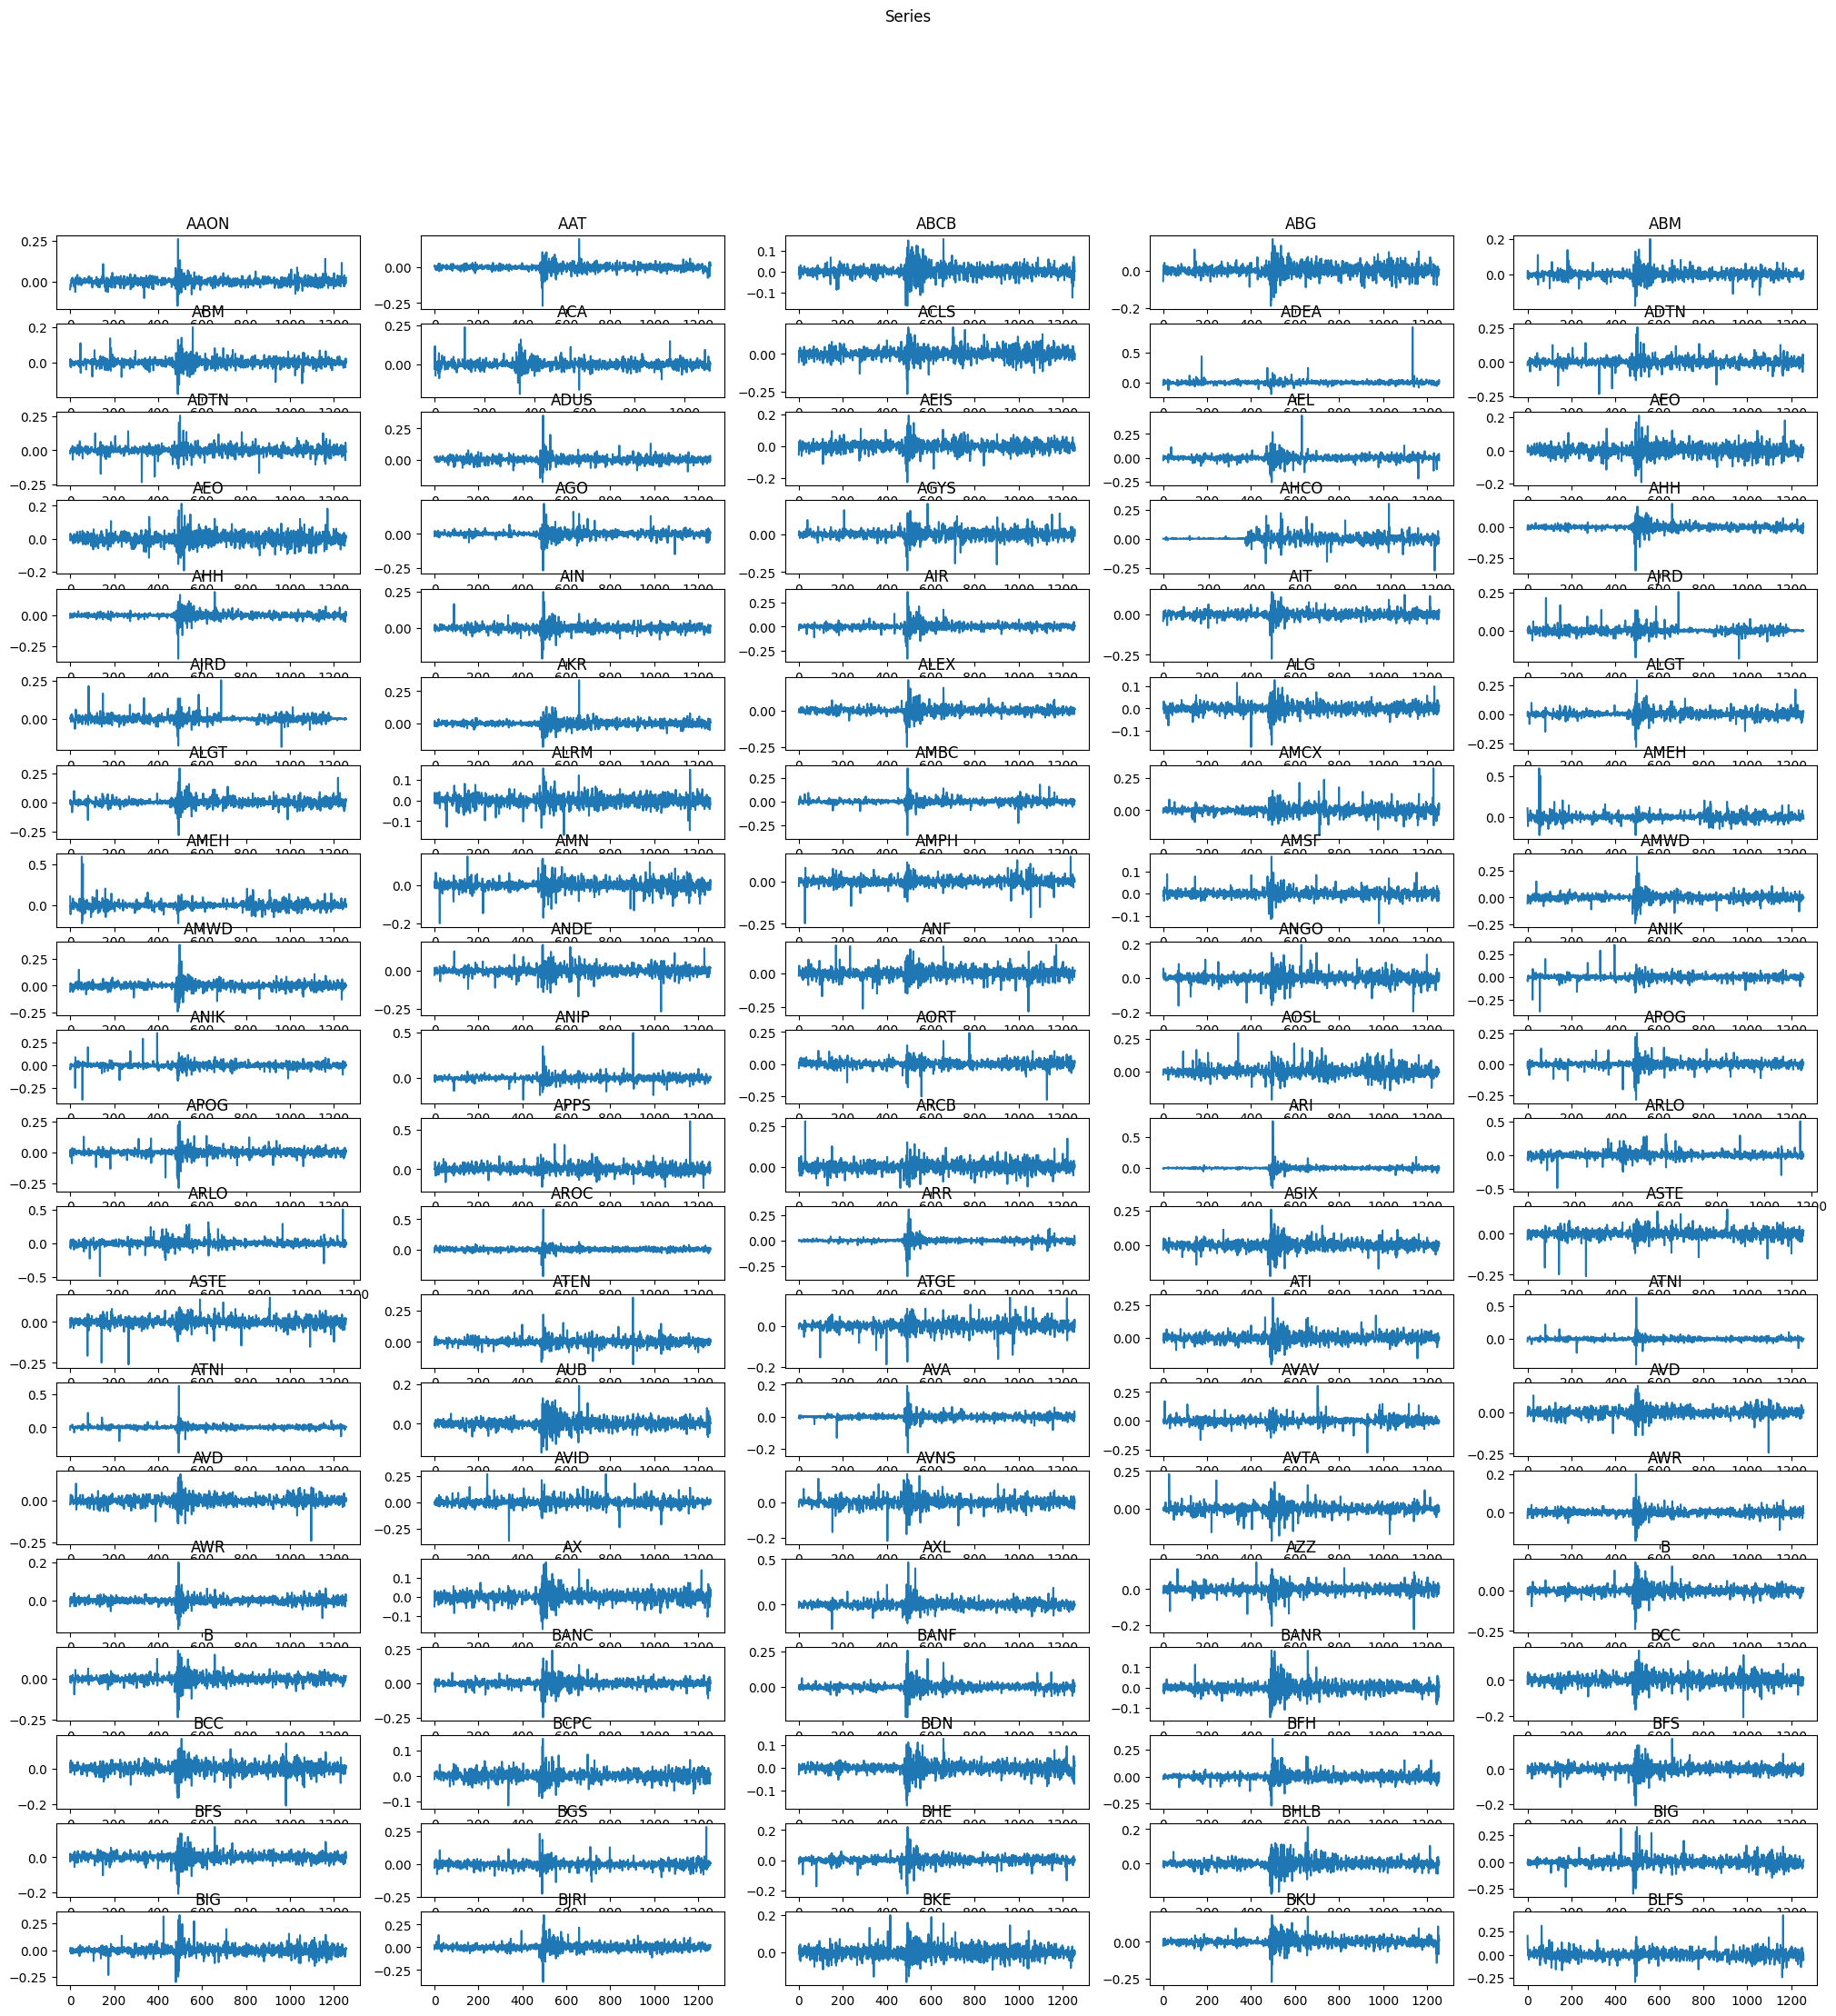

In [4]:
# plot the first 100 series
import matplotlib.pyplot as plt
fig, axs = plt.subplots(20,5,figsize=(25,25))
fig.suptitle('Series')
for i in range(20):
    for j in range(5):
        if i*4+j+1>len(df_list_daily_return): # pass the others that we can't fill
            continue
        axs[i, j].plot(df_list_daily_return[i*4+j].values)
        axs[i, j].set_title(ticker_downloaded[i*4+j])
plt.show()

In [5]:
series_lengths = {len(series) for series in df_list_daily_return}
print(series_lengths)

{1121, 993, 966, 1256, 1257, 1228, 942, 1199, 1104, 1169, 1170, 1141, 1109, 1244, 1214}


In [6]:
max_len = max(series_lengths)
longest_series = None
for series in df_list_daily_return:
    if len(series) == max_len:
        longest_series = series
print(len(longest_series))

1257


In [7]:
problems_index = []

for i in range(len(df_list_daily_return)):
    if len(df_list_daily_return[i])!= max_len:
        problems_index.append(i)
        df_list_daily_return[i] = df_list_daily_return[i].reindex(longest_series.index)

In [8]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [9]:
nan_counter(df_list_daily_return)

15


In [10]:
for i in problems_index:
    df_list_daily_return[i].interpolate(limit_direction="both",inplace=True, method='linear')

In [11]:
nan_counter(df_list_daily_return)

0


In [12]:
df_list_daily_return

[Date
 2018-04-02 00:00:00-04:00   -0.047436
 2018-04-03 00:00:00-04:00   -0.021534
 2018-04-04 00:00:00-04:00   -0.013755
 2018-04-05 00:00:00-04:00   -0.013947
 2018-04-06 00:00:00-04:00   -0.029703
                                ...   
 2023-03-22 00:00:00-04:00   -0.002945
 2023-03-23 00:00:00-04:00    0.010394
 2023-03-24 00:00:00-04:00   -0.011911
 2023-03-27 00:00:00-04:00    0.017096
 2023-03-28 00:00:00-04:00    0.023381
 Name: Daily Return, Length: 1257, dtype: float64,
 Date
 2018-04-02 00:00:00-04:00    0.005986
 2018-04-03 00:00:00-04:00    0.014579
 2018-04-04 00:00:00-04:00    0.012024
 2018-04-05 00:00:00-04:00    0.011301
 2018-04-06 00:00:00-04:00   -0.013467
                                ...   
 2023-03-22 00:00:00-04:00   -0.062741
 2023-03-23 00:00:00-04:00   -0.032296
 2023-03-24 00:00:00-04:00    0.037015
 2023-03-27 00:00:00-04:00    0.010532
 2023-03-28 00:00:00-04:00    0.015634
 Name: Daily Return, Length: 1257, dtype: float64,
 Date
 2018-04-02 00:00:00-0

In [13]:
from sklearn.preprocessing import MinMaxScaler

for i in range(len(df_list_daily_return)):
    scaler = MinMaxScaler()
    df_list_daily_return[i] = MinMaxScaler().fit_transform(df_list_daily_return[i].values.reshape(-1,1))
    df_list_daily_return[i]= df_list_daily_return[i].reshape(len(df_list_daily_return[i]))

In [14]:
print("max: "+str(max(df_list_daily_return[0]))+"\tmin: "+str(min(df_list_daily_return[0])))
print(df_list_daily_return[0][:5])

max: 1.0	min: 0.0
[0.2467917  0.3097543  0.3286639  0.32819835 0.28989805]


In [20]:

som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(df_list_daily_return))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(df_list_daily_return[0]), sigma=1, learning_rate = 0.0001)

som.random_weights_init(df_list_daily_return)
som.train(df_list_daily_return, 100000)

In [21]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5)
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

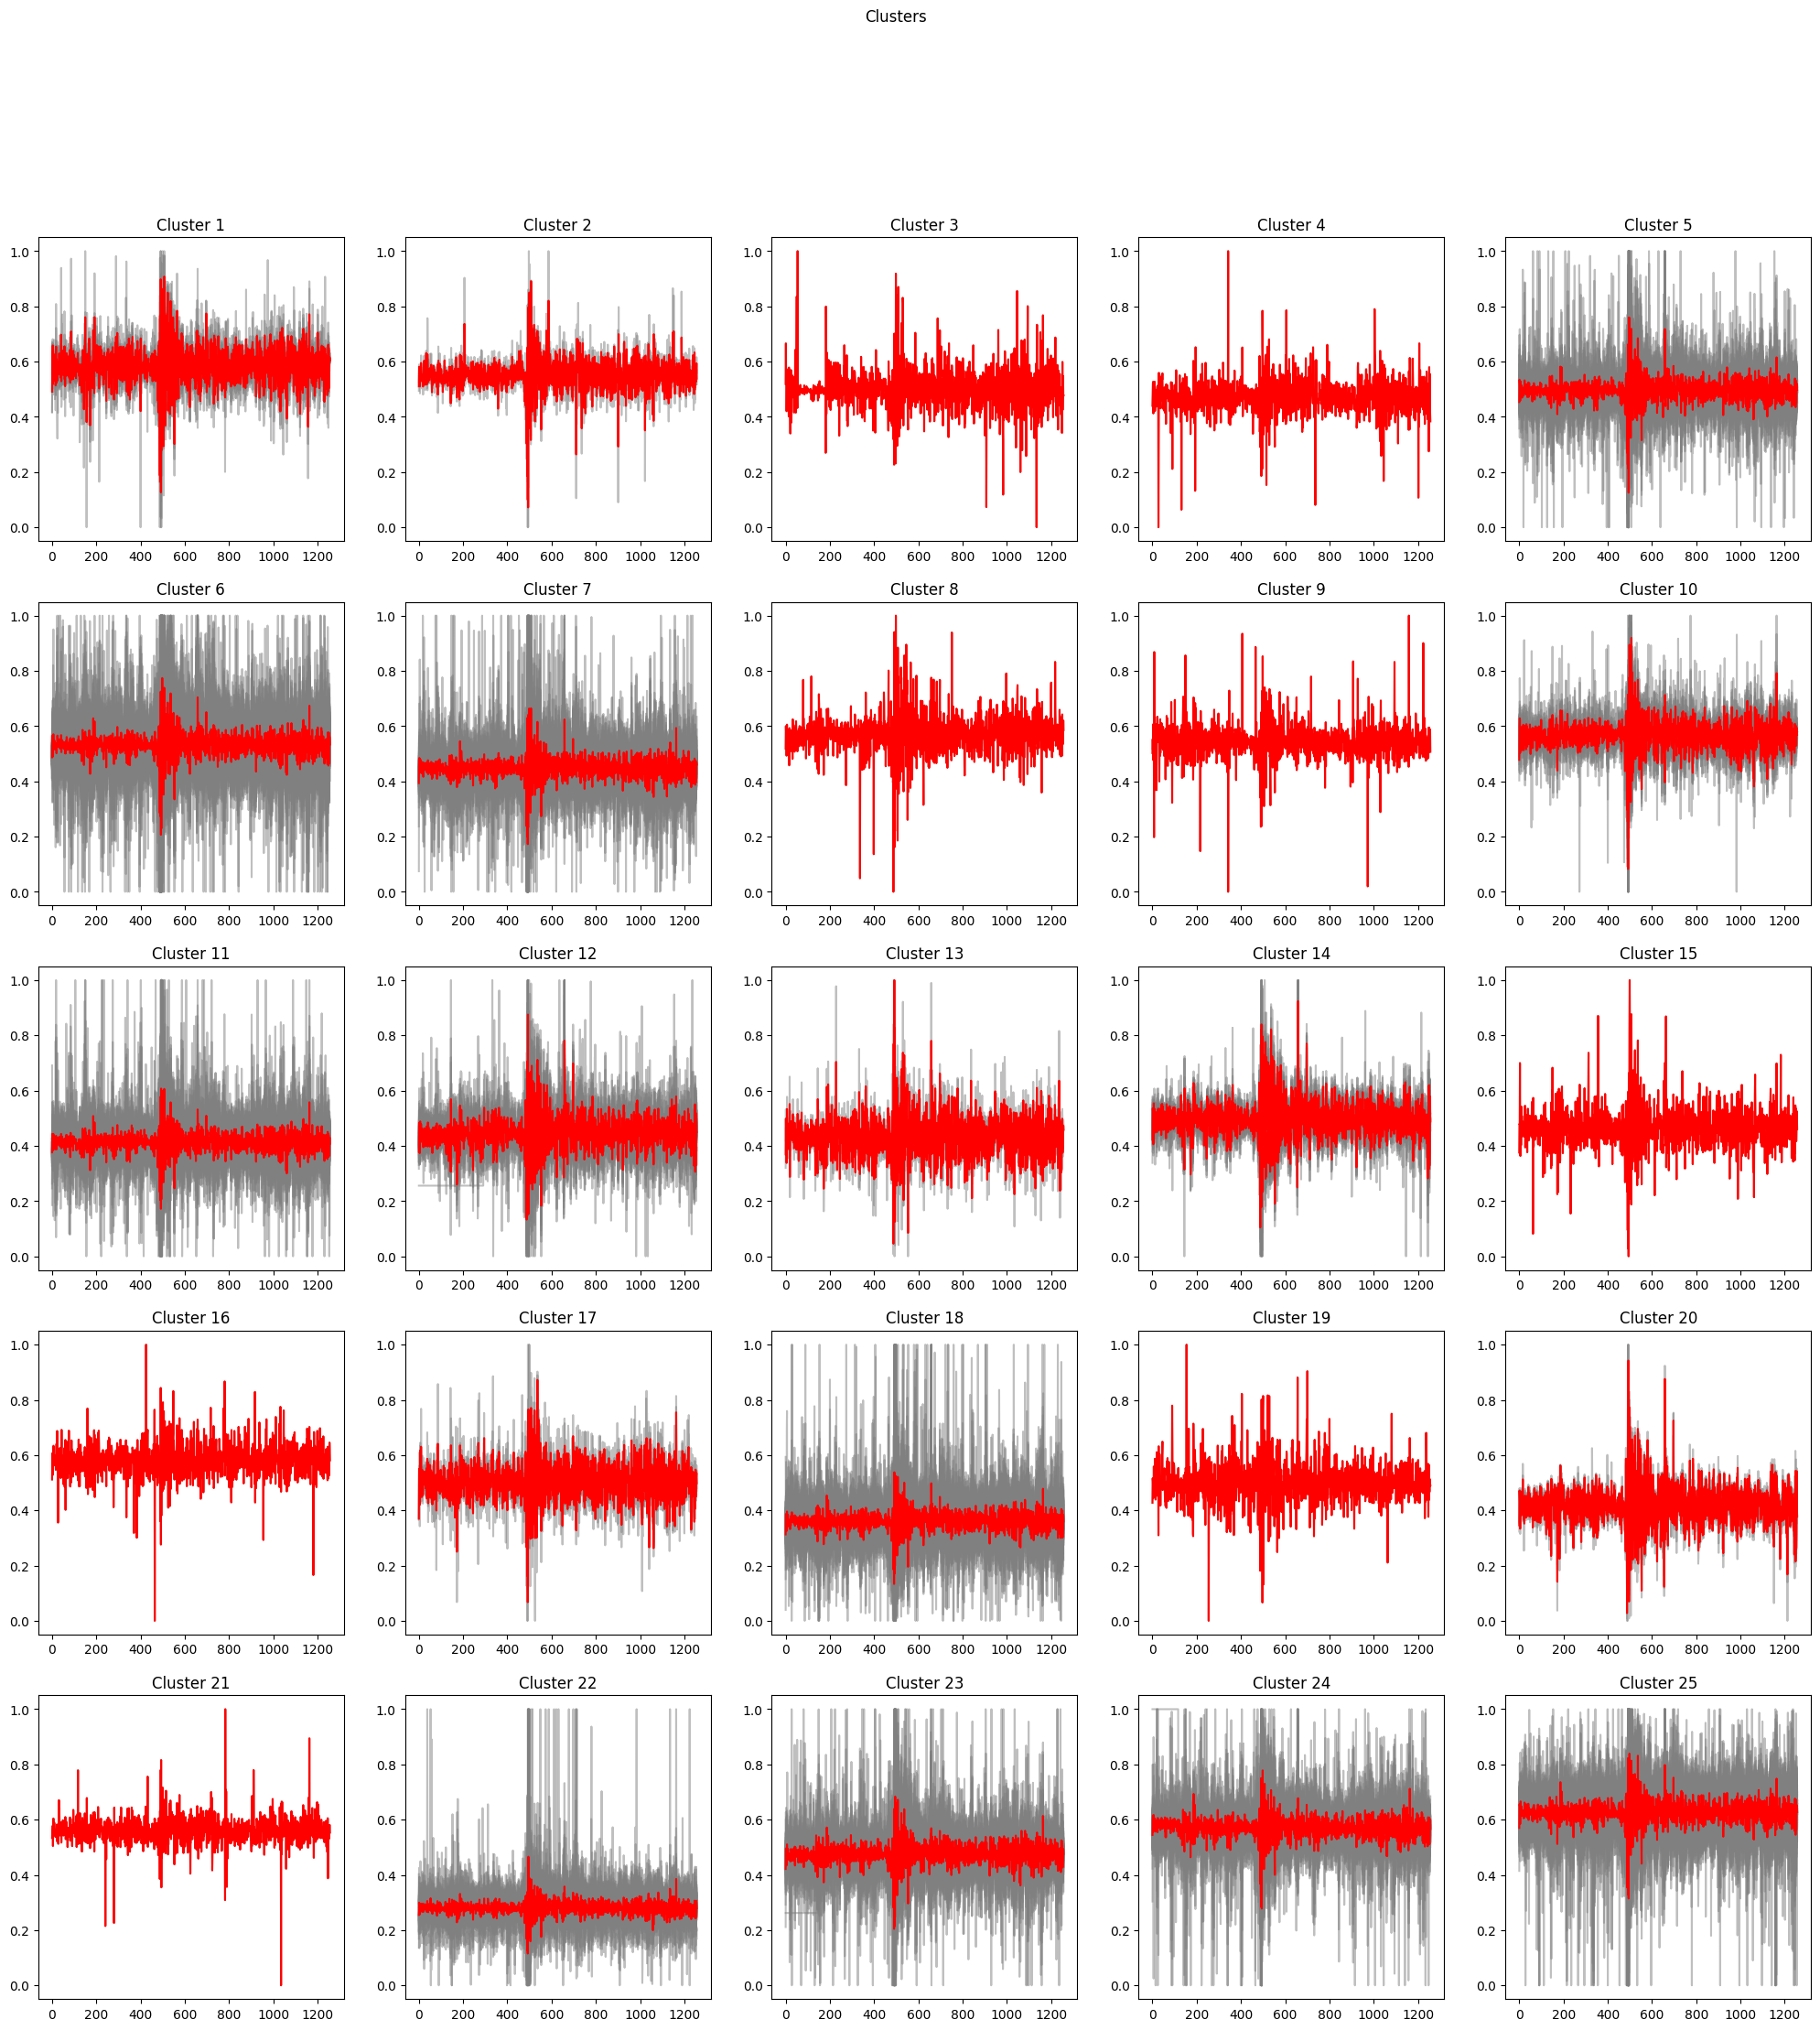

In [22]:
win_map = som.win_map(df_list_daily_return)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

In [23]:
# Obtenir la carte des nœuds gagnants
win_map = som.win_map(df_list_daily_return)

# Initialiser une liste de labels pour chaque cluster
cluster_labels = [[] for i in range(som_x * som_y)]

# Parcourir la liste de données et extraire les labels correspondants à chaque cluster
for i, data in enumerate(df_list_daily_return):
    # Trouver le nœud gagnant correspondant à la série de données
    node = som.winner(data)
    # Ajouter le label correspondant à la série de données à la liste de labels du cluster correspondant
    cluster_labels[node[0] * som_y + node[1]].append(ticker_downloaded[i])

# Afficher les labels pour chaque cluster
for i in range(som_x * som_y):
    print("Cluster ", i+1, " : ", cluster_labels[i])


Cluster  1  :  ['ALG', 'CRS', 'CVCO', 'FUL', 'LCII']
Cluster  2  :  ['AGYS', 'MCRI']
Cluster  3  :  ['RCII']
Cluster  4  :  ['CUTR']
Cluster  5  :  ['ALGT', 'AMBC', 'ANGO', 'BHE', 'CALM', 'CBRL', 'CHCT', 'CHEF', 'DIOD', 'DLX', 'GBX', 'GCO', 'GNL', 'GTY', 'HIBB', 'HNI', 'HSC', 'ICHR', 'INT', 'JBGS', 'MNRO', 'NSIT', 'OII', 'PEB', 'PRDO', 'PRGS', 'RDNT', 'RPT', 'SANM', 'SGH', 'SHAK', 'SKYW', 'TMST', 'UE', 'UFCS', 'XHR', 'YELP', 'ZYXI']
Cluster  6  :  ['AEIS', 'AGO', 'ALEX', 'ALRM', 'ANIK', 'AORT', 'APOG', 'ARR', 'AVA', 'BANC', 'BDN', 'BFS', 'BJRI', 'BLMN', 'BRC', 'CAKE', 'CARA', 'CBU', 'CENX', 'CEVA', 'CHS', 'CHUY', 'COHU', 'CPF', 'CRMT', 'CSGS', 'CTS', 'CUBI', 'CWK', 'CXW', 'CYTK', 'DIN', 'DORM', 'DY', 'ECPG', 'ENSG', 'EPRT', 'EYE', 'FARO', 'FBK', 'FBP', 'FFBC', 'FN', 'FWRD', 'GFF', 'GNW', 'GVA', 'HAIN', 'HBI', 'HCC', 'HCSG', 'HLX', 'HMN', 'HMST', 'HOUS', 'HP', 'HPP', 'IBTX', 'IDCC', 'IIIN', 'INN', 'INVA', 'ITGR', 'ITRI', 'JACK', 'JBSS', 'JJSF', 'KALU', 'KMT', 'KREF', 'KW', 'LPG', 'LRN',

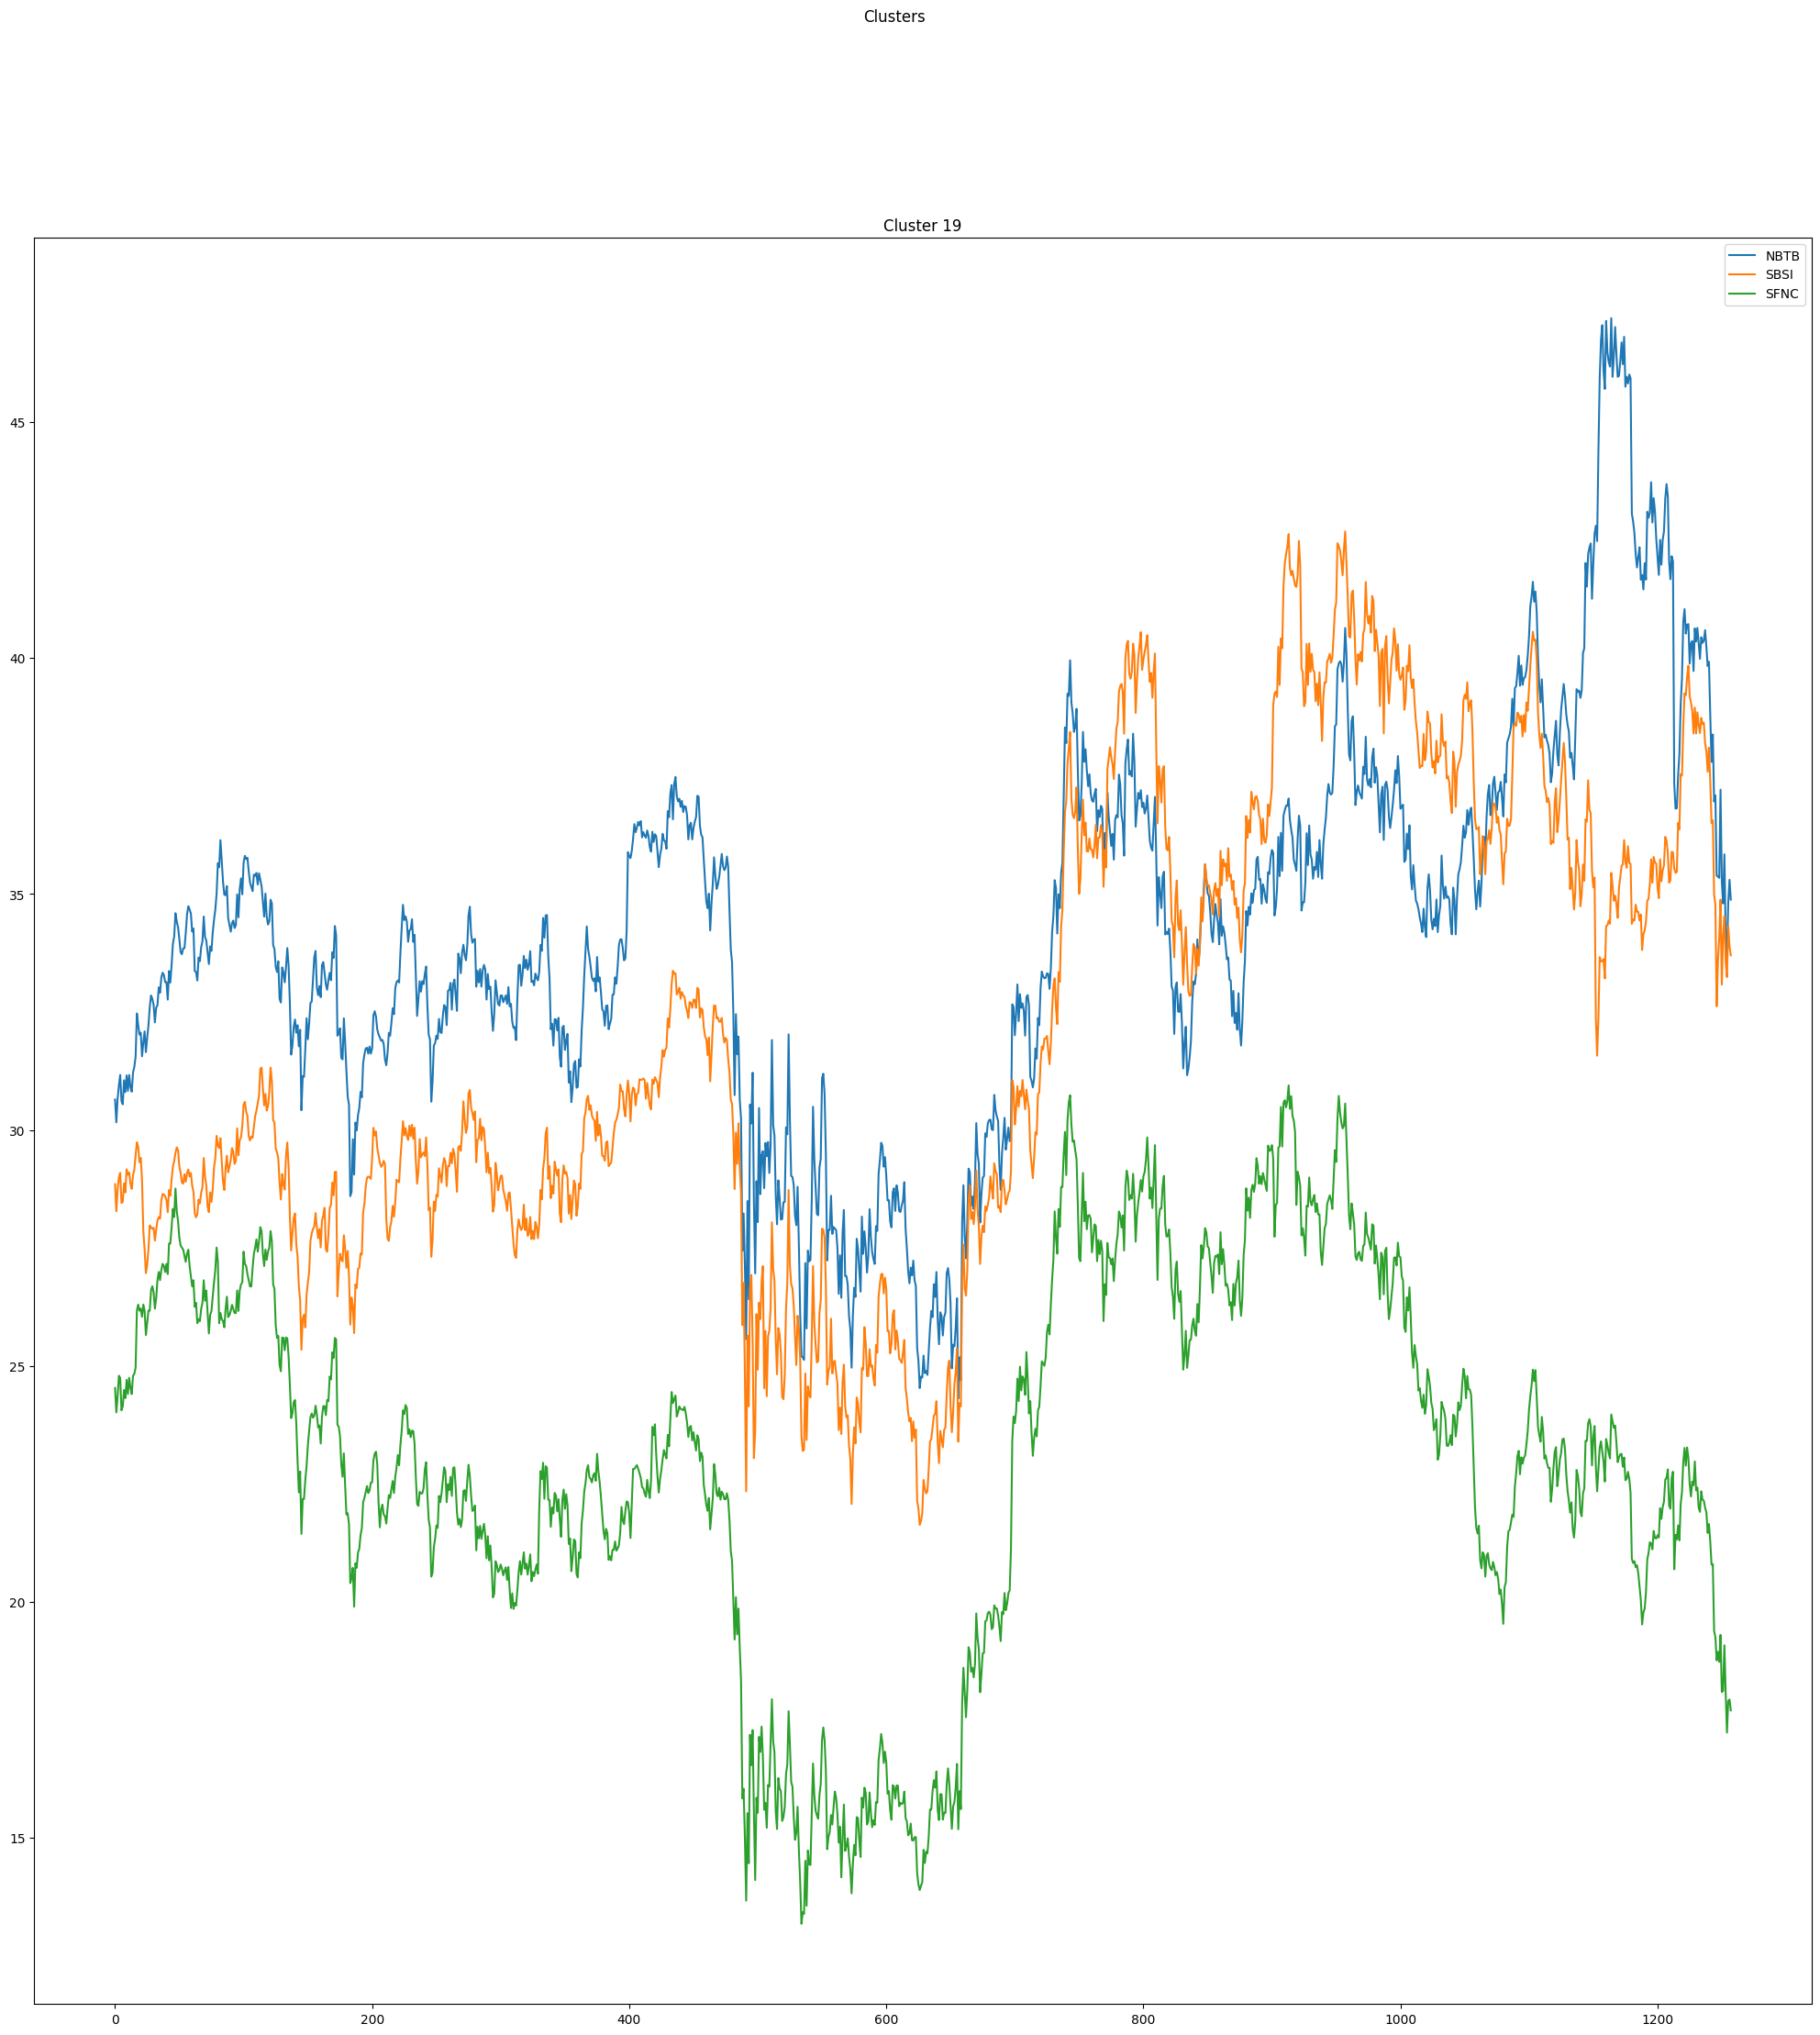

In [25]:
# plot each Close price of the stocks in the same cluster, cluster 1, in the same plot
# The close price is df_list['Close']

cluster_number = 19

fig, axs = plt.subplots(1,1,figsize=(25,25))
fig.suptitle('Clusters')
for ticker in cluster_labels[cluster_number]:
    axs.plot(df_list[ticker_downloaded.index(ticker)]['Close'].values)
    axs.set_title(f"Cluster {cluster_number}")
axs.legend(cluster_labels[cluster_number])